# Laporan Kelompok 7 - Traffic Management

Dataset : [Dataset](https://www.aiforsea.com/traffic-management)

*   Aditya Raybol Saragih
*   Yanuar Pratama Pandjaitan
*   Lutfi Rizky Ramadhan



In [1]:
pip install python-geohash

In [2]:
import numpy as np
import pandas as pd

import geohash as gh

import time

from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

from sklearn.preprocessing import  LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## 1 - Data Pre-Processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataset = "/content/drive/My Drive/DTSAI/Traffic/training.csv"
df = pd.read_csv(dataset)

In [5]:
df.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [6]:
len(df)

4206321

In [7]:
df.isnull().values.any()

False

In [0]:
df = df.sample(100000, random_state=1)

In [9]:
len(df)

100000

## 2 - Feature Engineering

In [0]:
traffic = pd.DataFrame()

konversi geohash menjadi longitude dan latitude, dan memasukkannya ke dalam kolom lng/lat

In [11]:
gh.decode('qp03wc')

(-5.35308837890625, 90.6536865234375)

In [0]:
def rounding(x):
    return round(float(x)*10000)/10000

In [13]:
rounding(gh.decode('qp03wc')[0])

-5.3531

In [14]:
rounding(gh.decode('qp03wc')[1])

90.6537

In [0]:
traffic['lat'] = df.apply(lambda x: rounding(gh.decode(x['geohash6'])[0]), axis=1)
traffic['lng'] = df.apply(lambda x: rounding(gh.decode(x['geohash6'])[1]), axis=1)

memisahkan jam dan menit

In [0]:
#memisahkan jam dan menit
traffic['hour'] = df.apply(lambda x: float(x['timestamp'].split(':')[0]), axis=1)
traffic['minute'] = df.apply(lambda x: float(x['timestamp'].split(':')[1]), axis=1)

mengubah day menjadi dow (day of week) dengan value 0-6

In [0]:
traffic['dow'] =  df.apply(lambda x: x['day']%7, axis=1)

In [0]:
traffic['demand'] = df.apply(lambda x : x['demand'], axis=1)

In [19]:
traffic.head()

,lat,lng,hour,minute,dow,demand
1825303,-5.3586,90.8185,20.0,30.0,0,0.139087
2150949,-5.4575,90.7416,11.0,15.0,5,0.150464
2756427,-5.4794,90.6866,11.0,15.0,6,0.064554
3750752,-5.3036,90.9393,12.0,15.0,2,0.019093
2996035,-5.3421,90.8075,23.0,0.0,5,0.054841


Mengurutkan data terhadap dow dan jam

In [20]:
trafficSorted = traffic.sort_values(by=['dow','hour'])
trafficSorted.head()

,lat,lng,hour,minute,dow,demand
1646326,-5.3476,90.5988,0.0,30.0,0,0.045039
2214690,-5.2927,90.9064,0.0,45.0,0,0.047002
3847656,-5.3751,90.8185,0.0,45.0,0,0.193589
3906796,-5.3970,90.6097,0.0,45.0,0,0.000795
1494472,-5.4190,90.8514,0.0,45.0,0,0.022094


In [21]:
trafficSorted.tail()

,lat,lng,hour,minute,dow,demand
4193493,-5.3201,90.5988,23.0,30.0,6,0.003014
2957280,-5.3476,90.7196,23.0,30.0,6,0.117911
1696509,-5.3256,90.9503,23.0,0.0,6,0.002407
3758910,-5.3751,90.5988,23.0,0.0,6,0.030590
1839726,-5.2927,90.6537,23.0,15.0,6,0.008649


Normalisasi fitur dengan MinMaxScaler

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
trafficSorted[['lat', 'lng', 'hour','dow']] = scaler.fit_transform(trafficSorted[['lat', 'lng', 'hour','dow']])

In [23]:
trafficSorted.head()

,lat,lng,hour,minute,dow,demand
1646326,0.555421,0.028609,0.0,30.0,0.0,0.045039
2214690,0.777508,0.828609,0.0,45.0,0.0,0.047002
3847656,0.444175,0.600000,0.0,45.0,0.0,0.193589
3906796,0.355583,0.056957,0.0,45.0,0.0,0.000795
1494472,0.266586,0.685566,0.0,45.0,0.0,0.022094


In [24]:
trafficSorted.tail()

,lat,lng,hour,minute,dow,demand
4193493,0.666667,0.028609,1.0,30.0,1.0,0.003014
2957280,0.555421,0.342783,1.0,30.0,1.0,0.117911
1696509,0.644417,0.942783,1.0,0.0,1.0,0.002407
3758910,0.444175,0.028609,1.0,0.0,1.0,0.030590
1839726,0.777508,0.171391,1.0,15.0,1.0,0.008649


In [0]:
trafficFeature = trafficSorted.iloc[:,[0,1,2,4]]
trafficDemand = trafficSorted.iloc[:,[5]]

In [26]:
trafficFeature.head()

,lat,lng,hour,dow
1646326,0.555421,0.028609,0.0,0.0
2214690,0.777508,0.828609,0.0,0.0
3847656,0.444175,0.600000,0.0,0.0
3906796,0.355583,0.056957,0.0,0.0
1494472,0.266586,0.685566,0.0,0.0


In [27]:
trafficDemand.head()

,demand
1646326,0.045039
2214690,0.047002
3847656,0.193589
3906796,0.000795
1494472,0.022094


membuat input shape untuk LSTM

In [28]:
X = []
for i in range(16):
    X.append(trafficFeature.shift(-1-i).fillna(-1).values)
X=np.array(X)
X = X.reshape(X.shape[1],X.shape[0],X.shape[2])
X.shape

(100000, 16, 4)

Splitting X dan Y untuk LSTM

In [0]:
# split into train and test
n_train = int(0.8*len(X))
trainX_lstm = X[:n_train,:,:]
testX_lstm = X[n_train:,:,:]

y = trafficDemand['demand'].values
trainY_lstm = y[:n_train]
testY_lstm = y[n_train:]

Splitting X dan Y untuk Regressor lain

In [0]:
(trainX, testX, trainY, testY) = train_test_split(trafficFeature, trafficDemand, test_size=0.2)

## 3 - Model Development

In [0]:
class Color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [0]:
def scoring(model, prediction, since):
  if model == "lin":
    print(Color.BOLD + "Linear Regression" + Color.END)
  elif model == "dt":
    print(Color.BOLD + "Decision Tree" + Color.END)
  elif model == "rf":
    print(Color.BOLD + "Random Forest" + Color.END)
  elif model == "xgb":
    print(Color.BOLD + "XGBoost Regression" + Color.END)
  trainingDuration = time.time() - since
  print("Training Duration : %d s" % (trainingDuration))
  R2 = r2_score(testY, prediction)
  MSE = mean_squared_error(testY, prediction)
  MAE = mean_absolute_error(testY, prediction)
  RMSE = np.sqrt(mean_squared_error(testY, prediction))
  print("R2 Score : " + Color.BOLD + str(R2) + Color.END)
  print("Mean Squared Error : " + Color.BOLD + str(MSE) + Color.END)
  print("Mean Absolute Error : " + Color.BOLD + str(MAE) + Color.END)
  print("Root Mean Squared Error : " + Color.BOLD + str(RMSE) + Color.END)
  print("\n")
  score = [R2, MSE, MAE, RMSE]
  return score

In [0]:
def scoringLSTM(prediction, since):
  print(Color.BOLD + "LSTM" + Color.END)

  trainingDuration = time.time() - since
  print("Training Duration : %d s" % (trainingDuration))
  
  R2 = r2_score(testY_lstm, prediction)
  MSE = mean_squared_error(testY_lstm, prediction)
  MAE = mean_absolute_error(testY_lstm, prediction)
  RMSE = np.sqrt(mean_squared_error(testY_lstm, prediction))
  print("R2 Score : " + Color.BOLD + str(R2) + Color.END)
  print("Mean Squared Error : " + Color.BOLD + str(MSE) + Color.END)
  print("Mean Absolute Error : " + Color.BOLD + str(MAE) + Color.END)
  print("Root Mean Squared Error : " + Color.BOLD + str(RMSE) + Color.END)
  print("\n")
  score = [R2, MSE, MAE, RMSE]
  return score

In [0]:
def lin():
  since = time.time()
  linreg = LinearRegression().fit(trainX, trainY)
  linpred = linreg.predict(testX)
  linscore = scoring("lin", linpred, since)
  return linscore

def dt():
  since = time.time()
  dtreg = tree.DecisionTreeRegressor().fit(trainX, trainY)
  dtpred = dtreg.predict(testX)
  dtscore = scoring("dt", dtpred, since)
  return dtscore

def rf(n_est=240, depth=25):
  since = time.time()
  rfreg = RandomForestRegressor(n_estimators=n_est, max_depth=depth).fit(trainX, trainY)
  rfpred = rfreg.predict(testX)
  rfscore = scoring("rf", rfpred, since)
  return rfscore

def xgbmodel(n_est=240, depth=25):
  since = time.time()
  xgbreg = xgb.XGBRegressor(n_estimators=n_est, max_depth=depth, learning_rate=0.01).fit(trainX, trainY)
  xgbpred = xgbreg.predict(testX)
  xgbscore = scoring("xgb", xgbpred, since)
  return xgbscore

def lstm():
  since = time.time()
  lstmModel = Sequential()
  lstmModel.add(LSTM(units=30, return_sequences= True, input_shape=(trainX_lstm.shape[1], trainX_lstm.shape[2])))
  lstmModel.add(LSTM(units=30, return_sequences=True))
  lstmModel.add(LSTM(units=30))
  lstmModel.add(Dense(units=1))
  lstmModel.summary()
  lstmModel.compile(optimizer='adam', loss='mean_squared_error')
  lstmModel.fit(trainX_lstm, trainY_lstm, epochs=3, batch_size=128)
  lstmpred = lstmModel.predict(testX_lstm)
  lstmscore = scoringLSTM(lstmpred, since)
  return lstmscore

In [35]:
linscore = lin()

Linear Regression
Training Duration : 0 s
R2 Score : 0.010558787076969667
Mean Squared Error : 0.025315016312388538
Mean Absolute Error : 0.09655168197554438
Root Mean Squared Error : 0.159106933577354




In [36]:
dtscore = dt()

Decision Tree
Training Duration : 0 s
R2 Score : 0.8115929818644426
Mean Squared Error : 0.004820424574169365
Mean Absolute Error : 0.03894688697294833
Root Mean Squared Error : 0.06942927749998098




In [37]:
rfscore = rf()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
Training Duration : 30 s
R2 Score : 0.8692315537180655
Mean Squared Error : 0.0033457322249527068
Mean Absolute Error : 0.033028920805323526
Root Mean Squared Error : 0.05784230480325543




In [38]:
xgbscore = xgbmodel()

[23:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Regression
Training Duration : 39 s
R2 Score : 0.7996269020759648
Mean Squared Error : 0.005126578695388718
Mean Absolute Error : 0.05589042751023229
Root Mean Squared Error : 0.07160013055427146




In [39]:
lstmscore = lstm()

W0815 23:09:40.125236 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 23:09:40.146556 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 23:09:40.149045 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 23:09:40.652224 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 30)            4200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,871
Trainable params: 18,871
Non-trainable params: 0
_________________________________________________________________


W0815 23:09:40.989533 140665214707584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0815 23:09:42.587577 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0815 23:09:42.738360 140665214707584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/3
80000/80000 [==============================] - 48s 604us/step - loss: 0.0268
Epoch 2/3
80000/80000 [==============================] - 46s 574us/step - loss: 0.0267
Epoch 3/3
80000/80000 [==============================] - 46s 572us/step - loss: 0.0267
LSTM
Training Duration : 158 s
R2 Score : -0.05436788421487759
Mean Squared Error : 0.020887115404879263
Mean Absolute Error : 0.09976699494303655
Root Mean Squared Error : 0.14452375377383214




## 4 - Evaluasi

In [0]:
label = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost Regression', 'LSTM']
r2 = [linscore[0], dtscore[0], rfscore[0], xgbscore[0], lstmscore[0]]
mse = [linscore[1], dtscore[2], rfscore[1], xgbscore[1], lstmscore[1]]
mae = [linscore[2], dtscore[3], rfscore[2], xgbscore[2], lstmscore[2]]
rmse = [linscore[3], dtscore[3], rfscore[3], xgbscore[3], lstmscore[3]]
index = np.arange(len(label))

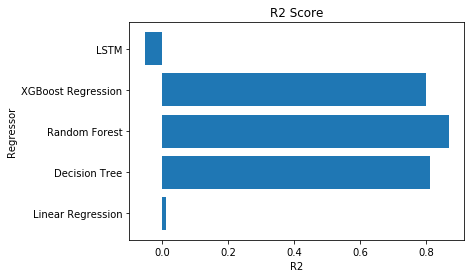

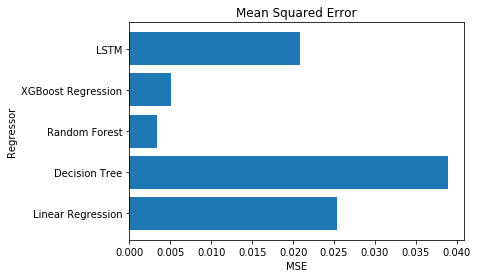

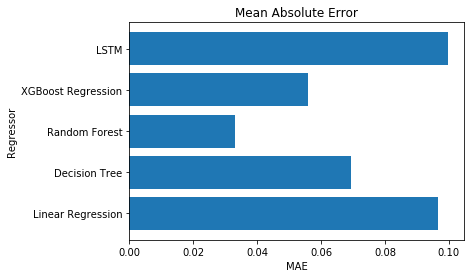

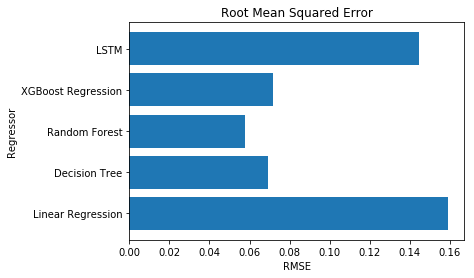

In [41]:
plt.figure()
plt.barh(index, r2)
plt.ylabel('Regressor')
plt.xlabel('R2')
plt.yticks(index, label)
plt.title('R2 Score')

plt.figure()
plt.barh(index, mse)
plt.ylabel('Regressor')
plt.xlabel('MSE')
plt.yticks(index, label)
plt.title('Mean Squared Error')

plt.figure()
plt.barh(index, mae)
plt.ylabel('Regressor')
plt.xlabel('MAE')
plt.yticks(index, label)
plt.title('Mean Absolute Error')

plt.figure()
plt.barh(index, rmse)
plt.ylabel('Regressor')
plt.xlabel('RMSE')
plt.yticks(index, label)
plt.title('Root Mean Squared Error')

plt.show()

## 5 Referensi

https://www.kaggle.com/naanzt/grab-ai-for-sea-challenge-traffic-management

https://www.kaggle.com/mahadir/grab-traffic-demand-forecasting#Neural-Network-(LSTM)